# House Prices Prediction - Costum Pipelines and Stacking Regression Techniques via Optuna 
---


1. [Introduction and Objectives](#introduction)
2. [Data Loading and Initial Exploration](#data-loading)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering and Custom Transformers](#feature-engineering)
5. [Statistical Outlier Detection and Z-Score Analysis](#outlier-detection)
6. [Data Preprocessing Pipeline](#preprocessing)
7. [Model Implementation and Baseline](#modeling)
8. [Automated Hyperparameter Optimization with Optuna](#optimization)
9. [Model Evaluation with Cross-Validation and Ensemble Analysis](#evaluation)
10. [Predictions and Kaggle Submission](#submission)


## Introduction

This notebook implements a production-ready machine learning pipeline for predicting house prices using the Kaggle House Prices dataset. The approach emphasizes automated optimization, ensemble learning, and robust evaluation practices suitable for real-world deployment. Involves statistical analysis, data preprocessing, feature engineering, costumized transformers/pipelines and stacking regression. Finally: model evaluation and selection via Optuna Hyperparameter Tuning


### Technical Implementation Strategy

The solution employs automated ensemble discovery where Optuna simultaneously optimizes model selection and hyperparameters across 9 different algorithm types. This eliminates manual model tuning while ensuring robust cross-validation evaluation. The final stacking architecture combines diverse base learners (linear, tree-based, kernel, instance-based) using a meta-learner that optimally weights predictions.

---

### Methodology
This project tackles house price prediction through ensemble learning pipeline that automates the entire model selection and optimization process.

**Custom Feature Engineering Pipeline**
- Built 8 custom sklearn transformers handling log transformations, age calculations, outlier removal, categorical encoding, and correlation filtering
- Created binary indicators for sparse features (like ScreenPorch, MasVnrArea) to capture zero/non-zero patterns
- Combined basement and ground floor areas into unified TotalSF feature
- Weighted bathroom counting (full baths = 1.0, half baths = 0.5) for better representation
- One-hot encoded categorical features with high cardinality (inspected manually) and non-ordinal. 
- Ordinal encoded categorical features with low cardinality (inspected manually).

**Outlier Detection System**
- Implemented z-score statistical analysis across all numerical features
- Generated comprehensive outlier tables ranking extreme values by magnitude
- Applied systematic outlier removal (|z| > 3.0) only on training data to prevent data leakage
- Preserved outliers in validation/test sets for realistic performance evaluation

**Automated Model Discovery with Optuna**
- 35/50 trial optimization discovering optimal ensemble compositions automatically
- Simultaneous hyperparameter tuning for 9 different algorithm types (Linear, Ridge, Lasso, ElasticNet, CatBoost, SVR, KNN, RandomForest, LightGBM, XGBoost)
- Dynamic model selection flags allowing Optuna to choose which algorithms to include
- Cross-validation scoring ensuring robust model evaluation

**Multi-Algorithm Stacking Architecture**
- Final ensemble combines 5 diverse base learners: Lasso, CatBoost, SVR, RandomForest, XGBoost
- Ridge regression meta-learner optimally weights base model predictions
- 5-fold cross-validation prevents overfitting during stacking
- Leverages different algorithm strengths: linear relationships (Lasso), non-linear patterns (trees), local patterns (SVR)

**Data Pipeline**
- Separate pipelines for train (with outlier removal) vs validation/test (without outlier removal)
- Consistent feature engineering across all datasets using fitted transformers
- DataFrame alignment
- Maintained pipeline order preventing any form of data leakage

**Model Evaluation**
- RMSE, R², and MAE metrics for complete performance assessment
- Residual analysis 
- Features importance analysis using SHAP values
- Optuna visualization tools showing optimization history and parameter importance
---

In [ ]:
# Core libraries and type hints for enhanced code clarity
from typing import List, Optional, Union, Dict, Any

In [ ]:
# Essential libraries for data manipulation, visualization, and machine learning
import pandas as pd
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading training and test datasets from Kaggle competition
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

In [ ]:
# Exploring dataset structure by examining all available features
sorted_columns = sorted(train_data.columns)
for column in sorted_columns:
    print(column)

1stFlrSF
2ndFlrSF
3SsnPorch
Alley
BedroomAbvGr
BldgType
BsmtCond
BsmtExposure
BsmtFinSF1
BsmtFinSF2
BsmtFinType1
BsmtFinType2
BsmtFullBath
BsmtHalfBath
BsmtQual
BsmtUnfSF
CentralAir
Condition1
Condition2
Electrical
EnclosedPorch
ExterCond
ExterQual
Exterior1st
Exterior2nd
Fence
FireplaceQu
Fireplaces
Foundation
FullBath
Functional
GarageArea
GarageCars
GarageCond
GarageFinish
GarageQual
GarageType
GarageYrBlt
GrLivArea
HalfBath
Heating
HeatingQC
HouseStyle
Id
KitchenAbvGr
KitchenQual
LandContour
LandSlope
LotArea
LotConfig
LotFrontage
LotShape
LowQualFinSF
MSSubClass
MSZoning
MasVnrArea
MasVnrType
MiscFeature
MiscVal
MoSold
Neighborhood
OpenPorchSF
OverallCond
OverallQual
PavedDrive
PoolArea
PoolQC
RoofMatl
RoofStyle
SaleCondition
SalePrice
SaleType
ScreenPorch
Street
TotRmsAbvGrd
TotalBsmtSF
Utilities
WoodDeckSF
YearBuilt
YearRemodAdd
YrSold


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# Creating train-validation split for model evaluation
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['SalePrice'], axis=1).copy()
y = train_data['SalePrice'].copy()

# Splitting data with 80-20 ratio, maintaining reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reconstructing training data for pipeline processing
train_data = X_train.join(y_train)

In [5]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 892 to 722
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             292 non-null    int64  
 1   MSSubClass     292 non-null    int64  
 2   MSZoning       292 non-null    object 
 3   LotFrontage    250 non-null    float64
 4   LotArea        292 non-null    int64  
 5   Street         292 non-null    object 
 6   Alley          17 non-null     object 
 7   LotShape       292 non-null    object 
 8   LandContour    292 non-null    object 
 9   Utilities      292 non-null    object 
 10  LotConfig      292 non-null    object 
 11  LandSlope      292 non-null    object 
 12  Neighborhood   292 non-null    object 
 13  Condition1     292 non-null    object 
 14  Condition2     292 non-null    object 
 15  BldgType       292 non-null    object 
 16  HouseStyle     292 non-null    object 
 17  OverallQual    292 non-null    int64  
 18  OverallCond  

Text(0.5, 0, 'Sale Price')

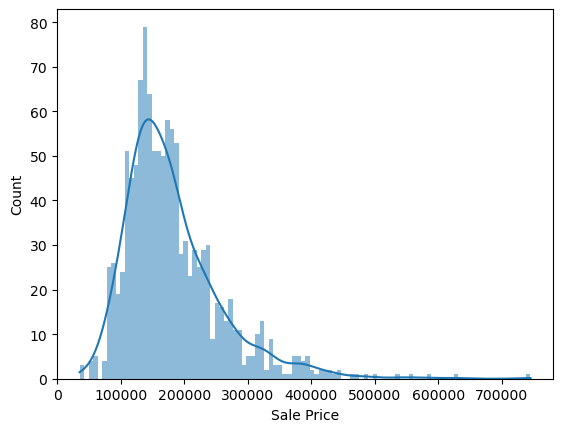

In [ ]:
# Analyzing target variable distribution to understand data characteristics
sns.histplot(train_data['SalePrice'], bins=100, kde = True, linewidth=0)
plt.xlabel('Sale Price')

In [ ]:
# Extracting numerical features for comprehensive analysis
numerical_values = train_data.select_dtypes(include=[np.number])

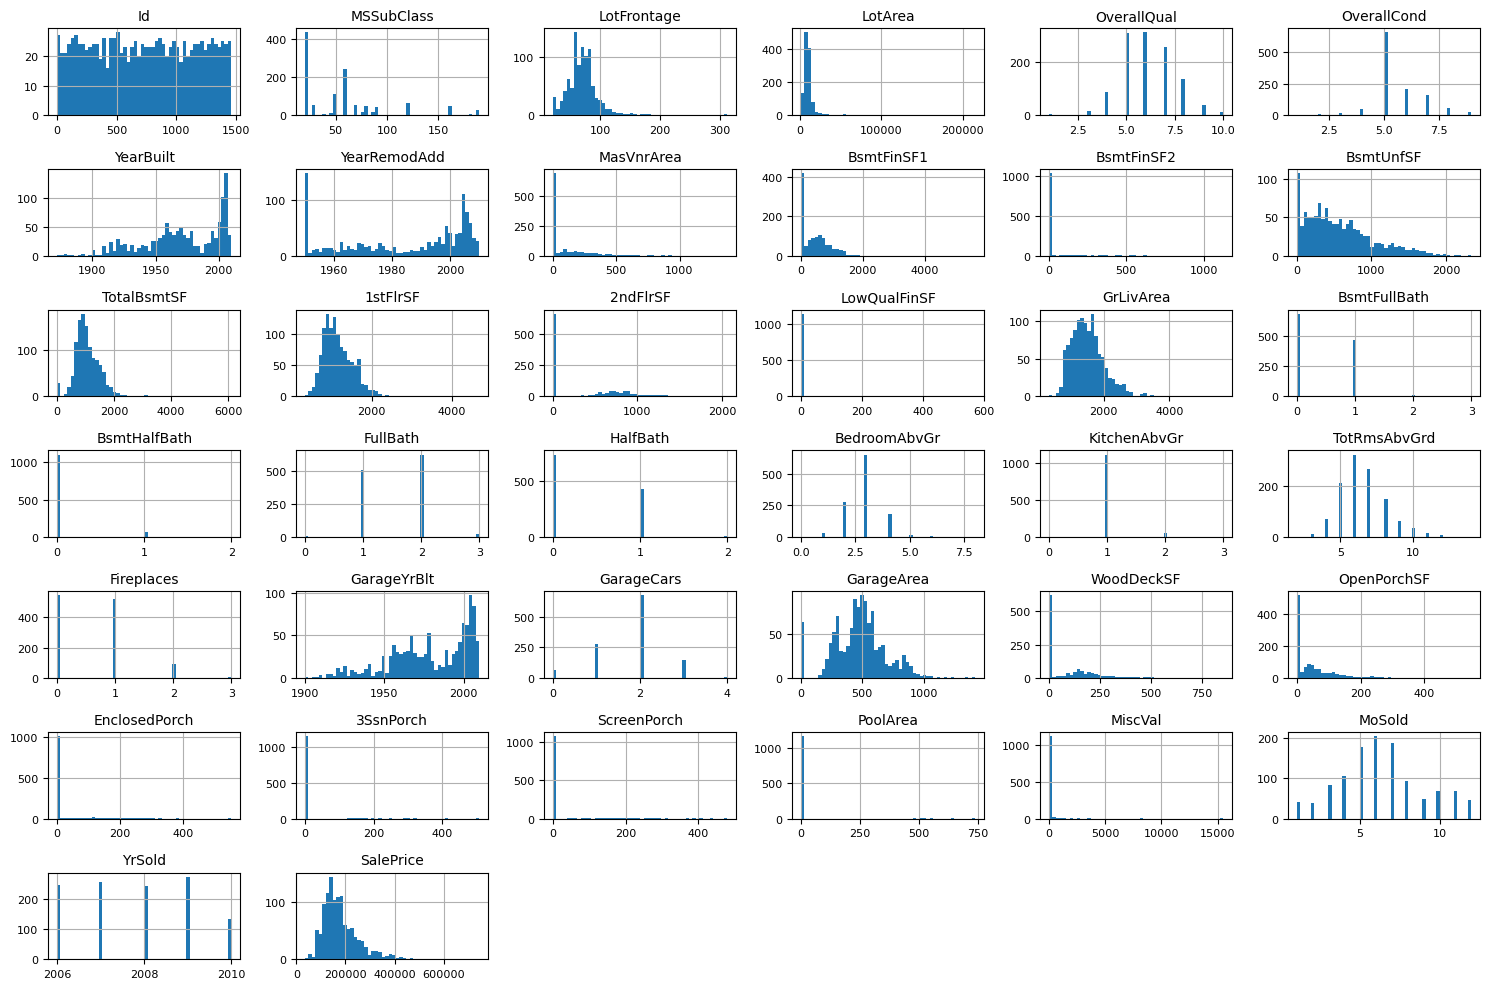

In [ ]:
# Creating comprehensive histogram visualization for all numerical features
numerical_values.hist(figsize=(15, 10), bins=50, xlabelsize=8, ylabelsize=8)
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=10)
plt.tight_layout()
plt.show()

In [9]:
numerical_values.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   LotFrontage    951 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   OverallQual    1168 non-null   int64  
 5   OverallCond    1168 non-null   int64  
 6   YearBuilt      1168 non-null   int64  
 7   YearRemodAdd   1168 non-null   int64  
 8   MasVnrArea     1162 non-null   float64
 9   BsmtFinSF1     1168 non-null   int64  
 10  BsmtFinSF2     1168 non-null   int64  
 11  BsmtUnfSF      1168 non-null   int64  
 12  TotalBsmtSF    1168 non-null   int64  
 13  1stFlrSF       1168 non-null   int64  
 14  2ndFlrSF       1168 non-null   int64  
 15  LowQualFinSF   1168 non-null   int64  
 16  GrLivArea      1168 non-null   int64  
 17  BsmtFullBath   1168 non-null   int64  
 18  BsmtHalfBat

## Feature Engineering and Custom Transformers 

### Log Transformation Strategy

Many numerical features exhibit significant right-skewness, particularly area-based measurements like LotArea, GrLivArea, and TotalBsmtSF. Applying log1p transformation reduces skewness and creates more Gaussian-like distributions, which enhances model performance for algorithms that assume normality.

The transformation also helps stabilize variance across different scales, making the data more suitable for linear models and improving convergence in gradient-based optimization algorithms. 
We apply the log transformation only on those features that are appear from continous from the manual investigation. Those features were selected one by one. 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformers implementing sklearn interface for systematic preprocessing

class LogTransformer(BaseEstimator, TransformerMixin):
    """Applies logarithmic transformation to reduce skewness in numerical features.
    Creates binary indicators for sparse features with high zero proportions."""
    
    def __init__(self, min_prop = 0.05, columns =["LotArea", "GrLivArea",
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF"]):
        self.min_prop = min_prop
        self.columns = columns

    def fit(self, X, y=None):
        # Identifying sparse columns for binary indicator creation
        self.sparse_columns = []
        for col in self.columns:
            value_counts = X[col].value_counts(normalize=True)
            zero_prop = value_counts.get(0, 0.0)
            if zero_prop >= self.min_prop: 
                self.sparse_columns.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        if self.columns is not None:
            for col in self.columns:
                X[col] = np.log1p(X[col])
                if col in self.sparse_columns:
                    X[f"has_{col}"] = (X[col] > 0).astype(int)
        return X

class dropColumns(BaseEstimator, TransformerMixin):
    """Removes specified columns that provide minimal predictive value or cause issues."""
    
    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X.drop(columns=col, inplace=True)
        return X

class AgeCalculator(BaseEstimator, TransformerMixin):
    """Computes house age from year sold and year built, providing temporal context."""
    
    def __init__(self, columns=["YrSold", "YearBuilt"]):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["HouseAge"] = (X[self.columns[0]] - X[self.columns[1]]).astype(int)
        X["HouseAge"] = X["HouseAge"].clip(lower=0)
        return X

class FeatureImputer(BaseEstimator, TransformerMixin):
    """Handles missing values with domain-specific strategies for different feature types."""
    
    def __init__(self, columns_zeros=[], columns_none = []):
        self.columns_zeros = columns_zeros
        self.columns_none = columns_none

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns_zeros:
            if col in X.columns:
                X[col] = X[col].fillna(0)
        for col in self.columns_none:
            if col in X.columns:
                X[col] = X[col].fillna("None")
        return X

class OutliersRemoval(BaseEstimator, TransformerMixin):
    """Removes predetermined outlier observations based on statistical analysis."""
    
    def __init__(self, rows_indexes =[1182, 1298, 1169, 224, 1190]):
        self.rows_indexes = rows_indexes 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for index in self.rows_indexes:
            if index in X.index:
                X = X.drop(index=index, errors='ignore')
        return X.reset_index(drop=True)
    
class YearImputer(BaseEstimator, TransformerMixin):
    """Imputes missing garage year built values while creating missingness indicators."""
    
    def __init__(self, column="GarageYrBlt", fill_value= None):
        self.column = column
        self.fill_value = fill_value
       
    def fit(self, X, y=None):
        if self.fill_value is None:
            self.fill_value = X[self.column].median()
        return self

    def transform(self, X):
        X = X.copy()
        X["GarageYrBlt_missing"] = (X[self.column]).isna().astype(int)
        X[self.column] = X[self.column].fillna(self.fill_value)
        return X

class HighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    """Identifies and removes highly correlated features to reduce multicollinearity."""
    
    def __init__(self, threshold=0.82):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        upper = corr_matrix.where(mask)
        self.to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')

## Outlier Detection and Analysis

### Statistical outlier detection using z-score

Outliers can significantly impact model performance, particularly for linear algorithms. The z-score method provides a standardized approach to identify observations that deviate substantially from the dataset mean.

The z-score transformation standardizes values by measuring how many standard deviations an observation lies from the mean:

$$z_{i,j} = \frac{x_{i,j} - \mu_j}{\sigma_j}$$

Where:
- $\mu_j = \frac{1}{n}\sum_{i=1}^n x_{i,j}$ is the sample mean
- $\sigma_j = \sqrt{\frac{1}{n}\sum_{i=1}^n (x_{i,j} - \mu_j)^2}$ is the sample standard deviation

Observations with $|z_{i,j}| > 3$ are typically considered outliers and may warrant removal or special treatment. In this context, we apply z-score analysis to all numerical features, but we only remove outliers from the training set to prevent data leakage. The validation and test sets retain all observations, including outliers, to ensure realistic performance evaluation. Not every outlier needs to be removed, some of them could contain valuable information, especially in real estate where extreme values can indicate unique properties or market conditions. For this reason, we kept msot of the outliers and manually investigate which one to remove later on.



In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(numerical_values, title="House Prices Regression Data Profiling Report", explorative=True)
profile.to_file("house_prices_regression.html")

In the html file `house_prices_regression.html`, we can find the data profiling report which includes the Z-score for each value in the specified columns. The report also provides insights into the distribution of the data, missing values, and other statistical properties.



In [ ]:
from scipy.stats import zscore 

def get_outlier_table(numerical_values: pd.DataFrame, thresh: float = 3.0):
    """Creates a comprehensive outlier analysis table using Z-score methodology.
    Returns sorted table of extreme values for systematic outlier identification."""
    
    # Computing Z-scores for all numerical features
    zscores  = pd.DataFrame(zscore(numerical_values, nan_policy="omit"), 
                            columns=numerical_values.columns, 
                            index=numerical_values.index)

    # Reshaping to long format for analysis
    long = (zscores.stack().reset_index().rename(columns={
            "level_0": "row_index",
            "level_1": "feature",
            0: "z_score"}))

    # Filtering extreme values based on threshold
    outliers = long[long["z_score"].abs() > thresh].copy()
    
    # Sorting by magnitude for prioritized outlier review
    outliers = outliers.reindex(
        outliers["z_score"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    return outliers

# Generating outlier analysis for systematic review
outlier_table = get_outlier_table(numerical_values, thresh=3.0)

# Examining outliers in key features for decision-making
for feature in ["LotArea", "GrLivArea", "SalePrice",
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF"]:
    if feature in outlier_table["feature"].values: 
        print(outlier_table[outlier_table["feature"] == feature].head(10))

def get_outliers_list(outlier_table: pd.DataFrame, n: int = 10):
    """Extracts list of most extreme outlier indices for removal consideration."""
    return outlier_table.head(n)["row_index"].tolist()

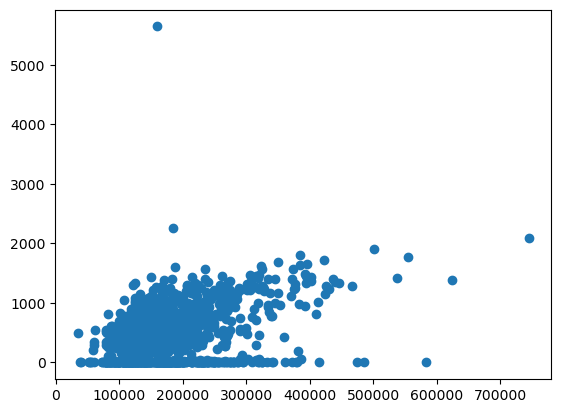

In [13]:
plt.scatter(x="SalePrice", y="BsmtFinSF1", data=train_data)

In [14]:
train_data.query("SalePrice > 500000")
#1182, 1298, 1169

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000


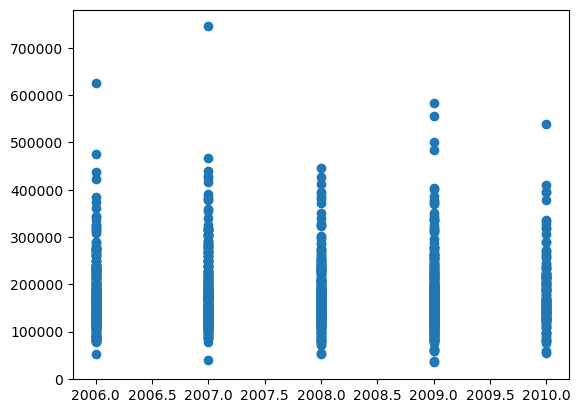

In [15]:
plt.scatter(x="YrSold", y="SalePrice", data=train_data)

In [6]:
pd.DataFrame(train_data.isnull().sum(), columns=['Null Count']).sort_values(by='Null Count', ascending=False).head(20)

,Null Count
PoolQC,1162
MiscFeature,1122
Alley,1094
Fence,935
MasVnrType,683
FireplaceQu,547
LotFrontage,217
GarageYrBlt,64
GarageCond,64
GarageType,64


### Categorical Feature Analysis

Examining categorical features to determine appropriate encoding strategies based on feature characteristics and relationships with the target variable.

In [24]:
# We used this cell to manually inspect the unique values of different columns
train_data["GarageFinish"].unique()

array(['RFn', nan, 'Unf', 'Fin'], dtype=object)

In [5]:
# We used this cell to manually fill some missing values in the dataset
train_data["BsmtFinType1"] = train_data["BsmtFinType1"].fillna("Unf")
train_data["BsmtFinType2"] = train_data["BsmtFinType2"].fillna("Unf")
train_data["Electrical"] = train_data["Electrical"].fillna("SBrkr")

X_val["BsmtFinType1"] = X_val["BsmtFinType1"].fillna("Unf")
X_val["BsmtFinType2"] = X_val["BsmtFinType2"].fillna("Unf")
X_val["Electrical"] = X_val["Electrical"].fillna("SBrkr")



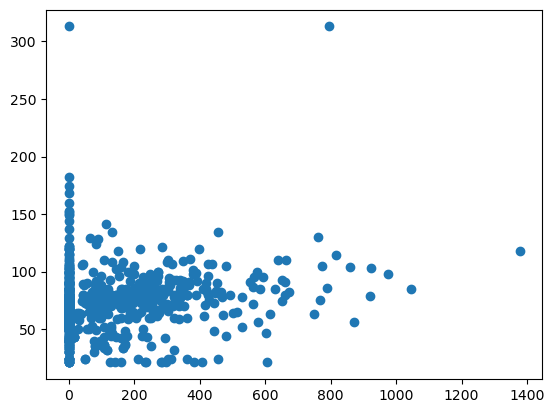

In [22]:
plt.scatter(x="MasVnrArea", y="LotFrontage", data=train_data)

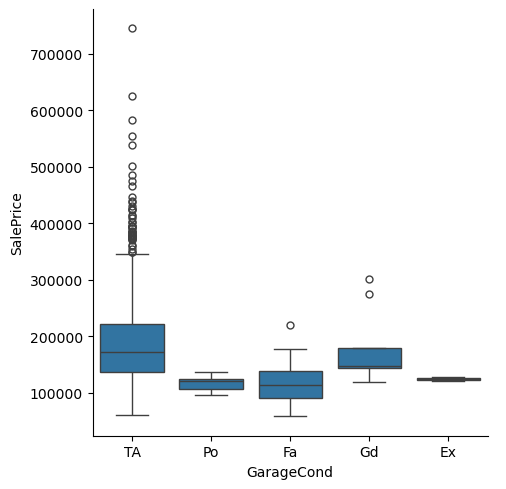

In [23]:
sns.catplot(x="GarageCond", y="SalePrice", data=train_data, kind="box")

In [6]:
'''Inspecting categorical features and their unique values'''

# Get all categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Create a list to store dictionaries with column info
column_info = []

# Populate the list
for col in categorical_columns:
    unique_vals = train_data[col].unique()
    column_info.append({'Feature': col, 'Unique_Values': list(unique_vals)})

# Create DataFrame from the list
feature_values_df = pd.DataFrame(column_info)

# Display the resulting dataframe
# Set pandas display options to show all values without truncation
pd.set_option('display.max_colwidth', None)
feature_values_df.head(5)   

,Feature,Unique_Values
0,MSZoning,"[RL, RM, FV, RH, C (all)]"
1,Street,"[Pave, Grvl]"
2,Alley,"[nan, Pave, Grvl]"
3,LotShape,"[Reg, IR1, IR2, IR3]"
4,LandContour,"[Lvl, Bnk, HLS, Low]"


In [ ]:
# Categorizing features based on encoding requirements

# Nominal categorical variables requiring one-hot encoding
one_hot_features = ["SaleType", "MiscFeature", "PavedDrive", "GarageType", "Electrical", 
                    "CentralAir", "Heating", "Foundation", "MasVnrType", "RoofMatl", 
                    "Exterior2nd", "RoofStyle", "HouseStyle", "BldgType", "Exterior1st", 
                    "Condition2", "Condition1", "Neighborhood", "LotConfig", "LotShape", 
                    "Street", "MSZoning", "SaleCondition"]

# Ordinal categorical variables with inherent quality ordering
ordinal_features = ["GarageCond", "GarageQual", "GarageFinish", "FireplaceQu", 
                    "Functional", "KitchenQual", "HeatingQC", "BsmtFinType2", "BsmtFinType1", 
                    "BsmtExposure", "BsmtCond", "BsmtQual", "ExterCond", "ExterQual",
                    "LandSlope", "Utilities", "LandContour"]

In [ ]:
# Defining ordinal mappings with proper quality hierarchies from worst to best
ordinal_features_dict = { 
    "GarageCond":  ["Po", "Fa", "TA", "Gd", "Ex", "None"],
    "GarageQual":  ["Po", "Fa", "TA", "Gd", "Ex", "None"],
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex", "None"],
    "KitchenQual": ["None","Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC":   ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond":    ["Po", "Fa", "TA", "Gd", "Ex", "None"],
    "BsmtQual":    ["Po", "Fa", "TA", "Gd", "Ex", "None"],
    "ExterCond":   ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterQual":   ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "Functional": ["None", "Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    "BsmtFinType1": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtExposure": ["None", "No", "Mn", "Av", "Gd"],
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "Utilities": ["None", "ELO", "NoSeWa", "NoSewr", "AllPub"],
    "LandContour": ["Lvl", "Bnk", "HLS", "Low"],
}

In [ ]:
# Advanced feature engineering transformers for categorical and derived features

class CatEncoder(BaseEstimator, TransformerMixin):
    """Handles both one-hot and ordinal encoding with proper categorical handling.
    Ensures consistent encoding across train/validation/test splits."""
    
    def __init__(self, one_hot_features=None, ordinal_features_levels=None, drop_first=True):
        self.one_hot_features = one_hot_features or []
        self.ordinal_features_levels = ordinal_features_levels or {}
        self.drop_first = drop_first
        self.dummy_cols = None

    def fit(self, X, y=None):
        X = X.copy().fillna("Missing")
        
        # Establishing dummy column structure during fit phase
        ohe = pd.get_dummies(X[self.one_hot_features], drop_first=self.drop_first, dtype='uint8')
        self.dummy_cols = list(ohe.columns)
        return self

    def transform(self, X):
        X = X.copy().fillna("Missing")
        
        # Applying ordinal encoding with predefined hierarchies
        for col, order in self.ordinal_features_levels.items():
            if col in X.columns:
                cat_type = pd.api.types.CategoricalDtype(categories=order, ordered=True)
                X[col] = X[col].astype(cat_type).cat.codes

        # Creating one-hot encoded features
        ohe = pd.get_dummies(X[self.one_hot_features], drop_first=self.drop_first, dtype='uint8')
        
        # Ensuring consistent column structure across datasets
        for col in self.dummy_cols: # type: ignore
            if col not in ohe.columns:
                ohe[col] = 0
        
        ohe = ohe[self.dummy_cols]
        X = X.drop(columns=self.one_hot_features)
        return pd.concat([X, ohe], axis=1)

class TotalArea(BaseEstimator, TransformerMixin):
    """Creates comprehensive area feature by combining basement and ground floor areas."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["TotalSF"] = (X["TotalBsmtSF"] + X["GrLivArea"])
        X.drop(columns=["TotalBsmtSF", "GrLivArea"], inplace=True, errors='ignore')
        return X
    
class TotalBaths(BaseEstimator, TransformerMixin):
    """Calculates total bathroom count including partial bathrooms with appropriate weighting."""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["TotalBaths"] = (X["FullBath"] + 0.5 * X["HalfBath"] + 
                           X["BsmtFullBath"] + 0.5 * X["BsmtHalfBath"])
        X.drop(columns=["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], inplace=True, errors='ignore')
        return X
    
class MedianImputer(BaseEstimator, TransformerMixin):
    """Imputes missing numerical values using median strategy for robustness against outliers."""
    
    def __init__(self, columns=None, fill_value=None):
        self.columns = columns if columns is not None else []
        self.fill_value = fill_value
    
    def fit(self, X, y=None):
        if self.fill_value is None:
            valid_columns = [col for col in self.columns if col in X.columns]
            if valid_columns:
                self.fill_value = X[valid_columns].median().to_dict()
            else:
                self.fill_value = {}
        return self

    def transform(self, X):
        X = X.copy()
        if self.fill_value is not None:
            for col in self.columns:
                if col in X.columns and col in self.fill_value:
                    X[col] = X[col].fillna(self.fill_value[col])
        return X

class ToDataFrame(BaseEstimator, TransformerMixin):
    """Ensures output maintains DataFrame structure with proper column names.
    Essential for pipeline compatibility and downstream processing."""
    
    def __init__(self):
        self.columns_ = None

    def fit(self, X, y=None):
        if hasattr(X, "columns"):
            self.columns_ = list(X.columns)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        return pd.DataFrame(X, columns=self.columns_)

<Axes: >

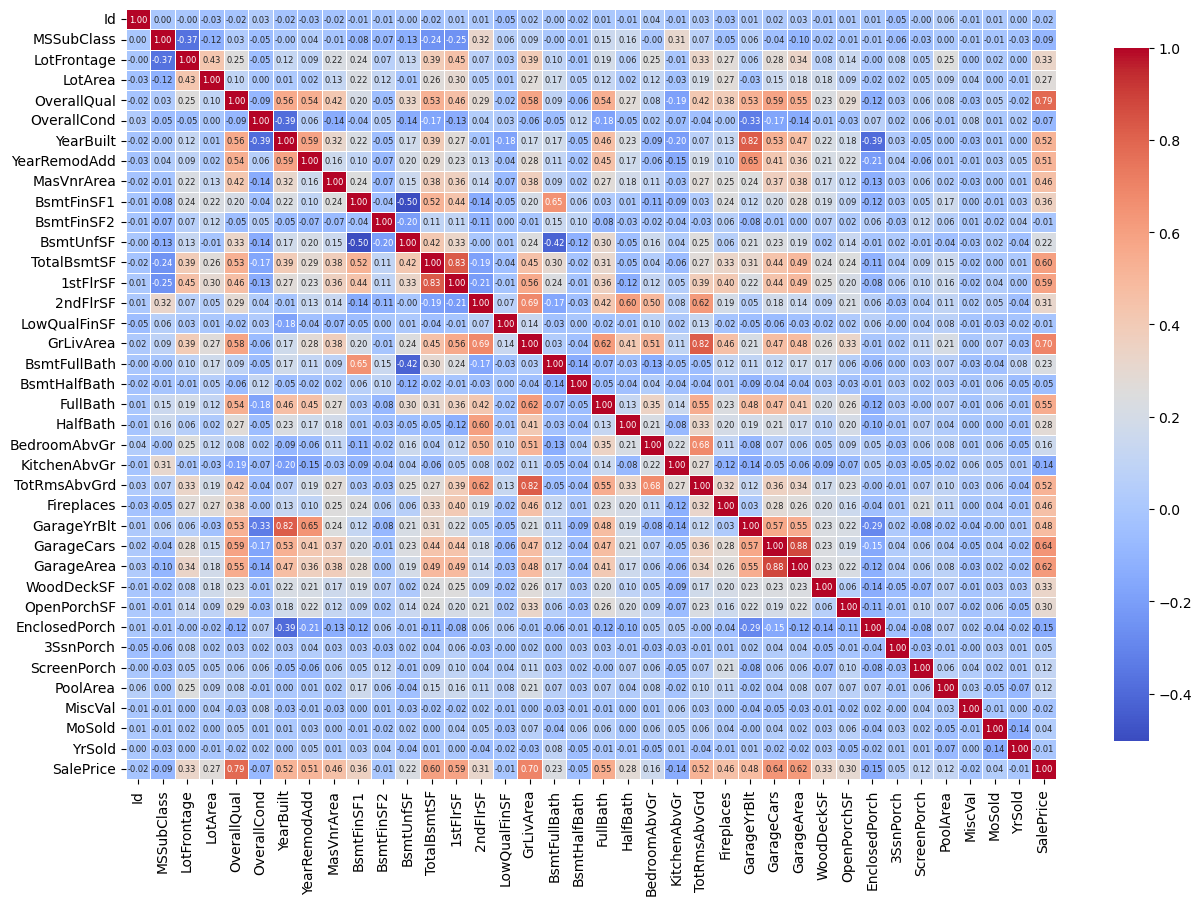

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_values.corr(), linewidth=0.4, annot=True, fmt=".2f", 
            cmap="coolwarm", annot_kws={"size": 6}, cbar_kws={"shrink": .9})

In [ ]:
## Data Preprocessing Pipeline {#preprocessing}

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from pandas import DataFrame

# Configuring sklearn to output pandas DataFrames for better data handling
set_config(transform_output="pandas")

# Defining feature imputation strategy for categorical variables
none_fill_features: list = ["BsmtExposure", "BsmtQual", "GarageQual", 
                            "GarageFinish", "GarageType", "GarageCond", "BsmtCond",
                            "FireplaceQu", "MasVnrType", "Exterior1st", "BsmtFinType1",
                            "BsmtFinType2", "Utilities", "Functional", "KitchenQual"  ]

# Features providing minimal predictive value or causing processing issues
columns_to_drop_regardless = ["MiscVal", "Alley", "PoolQC", "BsmtFinType2", "Fence"]

# Numerical pipeline for training data with outlier removal
pipeline_num_train = Pipeline([
    ("drop_columns", dropColumns(columns=["Id"] + columns_to_drop_regardless)),
    ("log_transformer", LogTransformer()),
    ("age_calculator", AgeCalculator()),
    ("outliers_removal", OutliersRemoval()),  # Training-specific outlier removal
    ("year_imputer", YearImputer()),
    ("total_area", TotalArea()),
    ("total_baths", TotalBaths()),
    ("lot_imputer", MedianImputer(["LotFrontage", "MasVnrArea", 
                                   "TotalBaths", "BsmtFinSF1",
                                   "TotalSF", "GarageCars", "BsmtUnfSF",
                                   "BsmtFinSF2", "GarageArea"], None)),
    ("standard_scaler", StandardScaler()),
    ("highly_correlated_features", HighlyCorrelatedFeatures(threshold=0.9)),
])

# Numerical pipeline for validation/test data without outlier removal
pipeline_num_val_test = Pipeline([
    ("drop_columns", dropColumns(columns=["Id"] + columns_to_drop_regardless)),
    ("log_transformer", LogTransformer()),
    ("age_calculator", AgeCalculator()),
    ("year_imputer", YearImputer()),
    ("total_area", TotalArea()),
    ("total_baths", TotalBaths()),
    ("lot_imputer", MedianImputer(["LotFrontage", "MasVnrArea", 
                                   "TotalBaths", "BsmtFinSF1",
                                   "TotalSF", "GarageCars", "BsmtUnfSF",
                                   "BsmtFinSF2", "GarageArea"], None)),
    ("standard_scaler", StandardScaler()),
    ("highly_correlated_features", HighlyCorrelatedFeatures(threshold=0.9)),
])

# Categorical pipeline for training data
pipeline_cat_train = Pipeline([
    ("drop_columns_cat", dropColumns(columns=["Id"] + columns_to_drop_regardless)),
    ("outliers_removal", OutliersRemoval()),  # Consistent outlier handling
    ("feature_imputer", FeatureImputer([], none_fill_features)),
    ("categorical_encoder", CatEncoder(one_hot_features=one_hot_features, 
                                               ordinal_features_levels=ordinal_features_dict)),
])

# Categorical pipeline for validation/test data
pipeline_cat_val_test = Pipeline([
    ("drop_columns_cat", dropColumns(columns=["Id"] + columns_to_drop_regardless)),
    ("feature_imputer", FeatureImputer([], none_fill_features)),
    ("categorical_encoder", CatEncoder(one_hot_features=one_hot_features, 
                                               ordinal_features_levels=ordinal_features_dict)),
])  

# Target variable pipeline ensuring consistent outlier removal
y_train_pipeline = Pipeline([
    ("OutliersRemoval", OutliersRemoval()),])

# Extracting feature sets for pipeline processing
X_num_train = train_data.select_dtypes(include=[np.number]).drop(columns=["SalePrice"], errors='ignore').copy()
X_cat_train = train_data.select_dtypes(include=['object']).copy()
y_train = train_data['SalePrice'].copy()
y_train = y_train_pipeline.fit_transform(y_train)

X_cat_val = X_val.select_dtypes(include=['object']).copy()
X_num_val= X_val.select_dtypes(include=[np.number]).copy()

# Preserving test IDs for submission file creation
test_ids = test_data['Id'].copy()
X_cat_test = test_data.select_dtypes(include=['object']).copy()
X_num_test = test_data.select_dtypes(include=[np.number]).copy()

# Systematic pipeline execution with proper fit/transform strategy
# Training data: fit and transform with outlier removal
num_train = pd.DataFrame(pipeline_num_train.fit_transform(X_num_train))
cat_train = pd.DataFrame(pipeline_cat_train.fit_transform(X_cat_train))

# Fitting validation/test pipelines on training data for consistency
pipeline_num_val_test.fit(X_num_train)
pipeline_cat_val_test.fit(X_cat_train)

# Transforming validation/test data using fitted parameters
num_val = pd.DataFrame(pipeline_num_val_test.transform(X_num_val))
cat_val = pd.DataFrame(pipeline_cat_val_test.transform(X_cat_val))
num_test = pd.DataFrame(pipeline_num_val_test.transform(X_num_test))
cat_test = pd.DataFrame(pipeline_cat_val_test.transform(X_cat_test))

### **Pipeline Strategy for Different Datasets**

When handling train/validation/test data, we need different pipeline strategies:

- Outlier Removal Problem

- Fitting Strategy

- Index Alignment

- Feature Creation Order


In [62]:
cat_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Columns: 159 entries, LandContour to SaleCondition_Partial
dtypes: int8(16), uint8(143)
memory usage: 180.7 KB


In [12]:
num_train.isnull().sum().sort_values(ascending=False).head(100)

MSSubClass             0
LotFrontage            0
OpenPorchSF            0
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
PoolArea               0
MoSold                 0
YrSold                 0
has_GarageArea         0
has_ScreenPorch        0
has_BsmtUnfSF          0
has_MasVnrArea         0
has_BsmtFinSF1         0
has_BsmtFinSF2         0
has_OpenPorchSF        0
HouseAge               0
GarageYrBlt_missing    0
TotalSF                0
WoodDeckSF             0
GarageArea             0
GarageCars             0
BsmtFinSF2             0
LotArea                0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
MasVnrArea             0
BsmtFinSF1             0
BsmtUnfSF              0
GarageYrBlt            0
1stFlrSF               0
2ndFlrSF               0
LowQualFinSF           0
BedroomAbvGr           0
KitchenAbvGr           0
TotRmsAbvGrd           0
Fireplaces             0
TotalBaths             0


In [63]:
num_test["TotalBaths"] = num_test["TotalBaths"].fillna(num_test["TotalBaths"].median())
num_test["TotalSF"] = num_test["TotalSF"].fillna(num_test["TotalSF"].median())
num_test["BsmtFinSF2"] = num_test["BsmtFinSF2"].fillna(num_test["BsmtFinSF2"].median())
num_test["BsmtUnfSF"] = num_test["BsmtUnfSF"].fillna(num_test["BsmtUnfSF"].median())

In [48]:
cat_test = cat_test.loc[:, ~cat_test.columns.duplicated()]


In [ ]:
# Combining numerical and categorical features into unified datasets
train_df  = num_train.join(cat_train)  
val_df  = num_val.join(cat_val)
test_df  = num_test.join(cat_test)

In [ ]:
# Ensuring consistent feature alignment across all datasets
common_columns = list(set(train_df.columns) & set(val_df.columns) & set(test_df.columns))

# Aligning all dataframes to common feature set
train_df = train_df[common_columns].copy()
val_df = val_df[common_columns].copy()
test_df= test_df[common_columns].copy()

In [65]:
print("shapes:", train_df.shape, val_df.shape, test_df.shape)
print("NaNs?  :", train_df.isnull().any().any(),
                  val_df.isnull().any().any(),
                  test_df.isnull().any().any())

shapes: (1163, 199) (292, 199) (1459, 199)
NaNs?  : False False False


In [56]:
#Removing any column that is in val/test but not in train: 
for col in val_df.columns:
    if col not in train_df.columns:
        val_df.drop(columns=col, inplace=True, errors='ignore')


In [52]:
#checking if val_df has some nan values
train_df.isnull().values.any()

False

In [53]:
dupes = cat_test.columns[cat_test.columns.duplicated()].unique()
print("duplicate columns:", dupes.tolist())


duplicate columns: []


In [54]:
test_df.isnull().sum().sort_values(ascending=False).head(50)

MSSubClass             0
Exterior1st_MetalSd    0
BldgType_Duplex        0
BldgType_Twnhs         0
BldgType_TwnhsE        0
Exterior1st_AsphShn    0
Exterior1st_BrkComm    0
Exterior1st_BrkFace    0
Exterior1st_CBlock     0
Exterior1st_CemntBd    0
Exterior1st_HdBoard    0
Exterior1st_ImStucc    0
Exterior1st_Plywood    0
LotFrontage            0
Exterior1st_Stone      0
Exterior1st_Stucco     0
Exterior1st_VinylSd    0
Exterior1st_Wd Sdng    0
Exterior1st_WdShing    0
Condition2_Feedr       0
Condition2_Norm        0
Condition2_PosA        0
Condition2_PosN        0
Condition2_RRAe        0
BldgType_2fmCon        0
HouseStyle_SLvl        0
HouseStyle_SFoyer      0
HouseStyle_2Story      0
Exterior2nd_CBlock     0
Exterior2nd_CmentBd    0
Exterior2nd_HdBoard    0
Exterior2nd_ImStucc    0
Exterior2nd_MetalSd    0
Exterior2nd_Other      0
Exterior2nd_Plywood    0
Exterior2nd_Stone      0
Exterior2nd_Stucco     0
Exterior2nd_VinylSd    0
Exterior2nd_Wd Sdng    0
Exterior2nd_Wd Shng    0


In [20]:
test_df.isnull().sum().sort_values(ascending=False).head(20)

MSSubClass             0
Exterior1st_MetalSd    0
BldgType_Duplex        0
BldgType_Twnhs         0
BldgType_TwnhsE        0
Exterior1st_AsphShn    0
Exterior1st_BrkComm    0
Exterior1st_BrkFace    0
Exterior1st_CBlock     0
Exterior1st_CemntBd    0
Exterior1st_HdBoard    0
Exterior1st_ImStucc    0
Exterior1st_Plywood    0
LotFrontage            0
Exterior1st_Stone      0
Exterior1st_Stucco     0
Exterior1st_VinylSd    0
Exterior1st_Wd Sdng    0
Exterior1st_WdShing    0
Condition2_Feedr       0
dtype: int64

In [ ]:
## Model Implementation {#modeling}

# Establishing baseline performance with linear regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score

model_LR = LinearRegression()
model_LR.fit(train_df, y_train)

# Evaluating baseline model performance
y_pred_lr = model_LR.predict(val_df)
rmse_lr = root_mean_squared_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

print(f" RMSE: {rmse_lr:,.2f}")
print(f" R² Score: {r2_lr:.4f}")

 RMSE: 30,632.95
 R² Score: 0.8777


## Model Evaluation and Analysis

### Ensemble Learning with Stacking Regressors

The following stacking implementation goes beyond simple model averaging by learning optimal combination weights through cross-validation. The system automatically discovers which algorithms work best together and how to weight their predictions. 

**Current Ensemble Architecture:**
- **5 Base Learners**: Automatically selected by Optuna from 9 algorithm options
- **Meta-Learning Strategy**: Ridge regression learns optimal weighting of base predictions  
- **Cross-Validation Prevention**: 5-fold CV ensures meta-learner doesn't overfit to base model outputs
- **Algorithm Diversity**: Combines complementary approaches (linear, tree-based, kernel, instance-based)

#### Implementation

**Base Model Selection Process:**
1. *Optuna Optimization*: Binary flags determine which algorithms to include
2. *Hyperparameter Tuning*: Each selected model gets optimized parameters
3. *Ensemble Size Control*: Minimum 2 models required (pruning single-model trials)
4. *Performance Evaluation*: Cross-validation scoring for robust model assessment

**Current Best Combination (Post-Optimization):**
- **Lasso Regression**: Captures linear relationships with feature selection (α=0.227)
- **CatBoost***: Handles categorical features and non-linear patterns (depth=4, lr=0.073)
- **Support Vector Regression**: Complex decision boundaries via kernel methods (C=0.764)
- **Random Forest**: Ensemble variance reduction (170 trees, depth=20)
- **XGBoost**: Extreme gradient boosting with regularization (170 trees, lr=0.073)

**Meta-Learner Configuration:**
- *Ridge Regression*: Optimal base model weighting (α=0.0025)
- *Cross-Validation*: 5-fold CV prevents meta-learner overfitting
- *Automatic Weight Learning*: No manual ensemble weight specification required

#### Performance Evaluation 

**Multi-Metric Assessment:**
- **RMSE**: Primary optimization target (root mean squared error)
- **R² Score**: Variance explanation measurement
- **MAE**: Outlier-robust error assessment (less sensitive to extreme values)

**Validation Approach:**
- **Held-Out Validation**: 20% of training data reserved for final evaluation
- **Outlier Preservation**: Validation/test sets retain outliers for realistic assessment
- **Residual Analysis**: Error distribution examination revealing model behavior on extreme values

This comprehensive evaluation ensures our ensemble generalizes well to unseen data.

In [ ]:
# Importing ensemble learning libraries and evaluation metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import cross_val_score as CrossValScore
from sklearn.model_selection import KFold 

# Core regression algorithms for ensemble construction
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, StackingRegressor,
                              GradientBoostingRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR

# Advanced gradient boosting frameworks
from xgboost import XGBRegressor as XGB
from lightgbm import LGBMRegressor as GBM
from catboost import CatBoostRegressor as CB

In [ ]:
# Hyperparameter optimization framework for automated model tuning
import optuna

## Hyperparameter Optimization with Optuna {#optimization}

**What We're Doing: Automated Ensemble Discovery**

Optuna handles the complex task of simultaneously optimizing two critical decisions:
1. **Which models to include** in our stacking ensemble (9 algorithm options)
2. **What hyperparameters** each selected model should use

**The Optimization Process:**
- **Trial-based Search**: Each trial tests a different combination of models and hyperparameters
- **Dynamic Ensemble Composition**: Binary flags (include_lr, include_lasso, etc.) let Optuna decide which algorithms to combine
- **Bayesian Optimization**: Optuna intelligently suggests parameter combinations based on previous trial results
- **Cross-Validation Scoring**: Every ensemble candidate gets evaluated using 5-fold CV to prevent overfitting

**Model Evaluation Strategy:**
- **Objective Function**: Maximizes negative RMSE (converts minimization to maximization problem)
- **Minimum Ensemble Size**: Trials with less than 2 models get pruned (stacking requires multiple base learners)
- **Performance Tracking**: Each trial records which models were selected for later analysis
- **Pruning Strategy**: Poor-performing trials get terminated early to save computation time

**Current Implementation Logic:**
The objective function creates a complete stacking pipeline for each trial, fits it using cross-validation, and returns the mean CV score. This approach ensures our final model selection is robust and generalizable, rather than just optimized for the training set.

In [ ]:
def objective(trial): 
    """Optuna objective function implementing comprehensive hyperparameter optimization.
    Simultaneously optimizes model selection and individual model parameters."""
    
    # Defining hyperparameter search spaces for each algorithm
    catboost_depth = trial.suggest_int("catboost_depth", 3, 10)
    catboost_learning_rate = trial.suggest_float("catboost_learning_rate", 1e-3, 0.3, log=True)
    catboost_iterations = trial.suggest_int("catboost_iterations", 50, 500, step=50)
    catboost_l2_leaf_reg = trial.suggest_float("catboost_l2_leaf_reg", 1e-3, 10.0, log=True)
    ridge_alpha = trial.suggest_float("ridge_alpha", 1e-3, 10.0, log=True)
    lasso_alpha = trial.suggest_float("lasso_alpha", 1e-3, 10.0, log=True)
    elastic_alpha = trial.suggest_float("elastic_alpha", 1e-3, 10.0, log=True)
    elastic_l1_ratio = trial.suggest_float("elastic_l1_ratio", 0.0, 1.0)
    svr_c = trial.suggest_float("svr_c", 1e-3, 10.0, log=True)
    svr_epsilon = trial.suggest_float("svr_epsilon", 1e-3, 1.0, log=True)
    knn_n_neighbors = trial.suggest_int("knn_n_neighbors", 1, 20)
    knn_weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])
    knn_algorithm = trial.suggest_categorical("knn_algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    knn_leaf_size = trial.suggest_int("knn_leaf_size", 1, 50)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 300, step=10)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 30, step=5)
    lgb_num_leaves = trial.suggest_int("lgb_num_leaves", 20, 500, step=10)
    lgb_max_depth = trial.suggest_int("lgb_max_depth", 5, 30, step=5)
    
    # Binary model selection flags enabling dynamic ensemble composition
    include_lr = trial.suggest_categorical("include_lr", [True, False])
    include_lasso = trial.suggest_categorical("include_lasso", [True, False])
    include_enet = trial.suggest_categorical("include_enet", [True, False])
    include_catboost = trial.suggest_categorical("include_catboost", [True, False])
    include_svr = trial.suggest_categorical("include_svr", [True, False])
    include_knn = trial.suggest_categorical("include_knn", [True, False])
    include_rf = trial.suggest_categorical("include_rf", [True, False])
    include_lgbm = trial.suggest_categorical("include_lgbm", [True, False])
    include_xgb = trial.suggest_categorical("include_xgb", [True, False])
    
    # Instantiating models with optimized hyperparameters
    CatBoost = CB(depth=catboost_depth,
                  learning_rate=catboost_learning_rate, 
                    iterations=catboost_iterations,
                    l2_leaf_reg=catboost_l2_leaf_reg,
                    random_state=42,)

    SVR_model = SVR(C=svr_c, epsilon=svr_epsilon)
    KNN_model = KNR(n_neighbors=knn_n_neighbors, 
                    weights=knn_weights, 
                    algorithm=knn_algorithm, 
                    leaf_size=knn_leaf_size)
    
    RF_model = RandomForestRegressor(n_estimators=rf_n_estimators, 
                                     max_depth=rf_max_depth, 
                                     random_state=42)
    
    LGBM_model = GBM(num_leaves=lgb_num_leaves,
                    max_depth=lgb_max_depth, 
                    learning_rate=catboost_learning_rate, 
                    random_state=42)
    
    XGB_model = XGB(n_estimators=rf_n_estimators,
                    max_depth=rf_max_depth, 
                    learning_rate=catboost_learning_rate,
                    random_state=42)
    Ridge_model = Ridge(alpha=ridge_alpha, random_state=42)
    Lasso_model = Lasso(alpha=lasso_alpha, random_state=42)
    ElasticNet_model = ElasticNet(alpha=elastic_alpha, 
                                 l1_ratio=elastic_l1_ratio, 
                                 random_state=42)
    
    # Building dynamic estimator list based on selection flags
    estimators = []

    if include_lr:
        estimators.append(("LR", LinearRegression()))
    if include_lasso:
        estimators.append(("Lasso", Lasso_model))
    if include_enet:
        estimators.append(("ElasticNet", ElasticNet_model))
    if include_catboost:
        estimators.append(("CatBoost", CatBoost))
    if include_svr:
        estimators.append(("SVR", SVR_model))
    if include_knn:
        estimators.append(("KNN", KNN_model))
    if include_rf:
        estimators.append(("RF", RF_model))
    if include_lgbm:
        estimators.append(("LGBM", LGBM_model))
    if include_xgb:
        estimators.append(("XGB", XGB_model))
        
    # Ensuring minimum ensemble size for meaningful stacking
    if len(estimators) < 2:
        raise optuna.exceptions.TrialPruned() 
    meta_model = Ridge_model

    # Creating stacking ensemble with dynamic composition
    stacking_model = StackingRegressor(estimators=estimators, 
                                       final_estimator=meta_model, 
                                       cv=5,
                                       n_jobs=-1)
    
    # Evaluating performance through cross-validation
    score = CrossValScore(stacking_model, train_df, y_train,
                          scoring = "neg_root_mean_squared_error",
                          cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs = -1) 
    
    # Recording selected models for analysis
    trial.set_user_attr("used_models", [name for name, _ in estimators])
    return score.mean()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-07-20 13:35:17,326] A new study created in memory with name: no-name-7467200d-c5a6-4b05-b615-60d4dce1c4ae
[I 2025-07-20 13:35:38,404] Trial 0 finished with value: -23344.364061041277 and parameters: {'catboost_depth': 4, 'catboost_learning_rate': 0.03729051651880161, 'catboost_iterations': 200, 'catboost_l2_leaf_reg': 0.0025064148337128694, 'ridge_alpha': 0.2861960776374833, 'lasso_alpha': 4.271739123176205, 'elastic_alpha': 2.611742246184815, 'elastic_l1_ratio': 0.8367283108129294, 'svr_c': 0.01842645759701136, 'svr_epsilon': 0.0016603913859349097, 'knn_n_neighbors': 10, 'knn_weights': 'distance', 'knn_algorithm': 'ball_tree', 'knn_leaf_size': 16, 'rf_n_estimators': 270, 'rf_max_depth': 5, 'lgb_num_leaves': 70, 'lgb_max_depth': 25, 'include_lr': False, 'include_lasso': False, 'include_enet': True, 'include_catboost': True, 'include_svr': True, 'include_knn': True, 'include_rf': False, 'include_lgbm': False, 'include_xgb': True}. Best is trial 0 with value: -23344.364061041277.

In [107]:
best = study.best_trial
df = study.trials_dataframe(attrs=("number", "value", "params", "user_attrs"))
print("Best model combination:", best.user_attrs["used_models"])

Best model combination: ['Lasso', 'CatBoost', 'SVR', 'RF', 'LGBM', 'XGB']


In [104]:
import optuna.visualization as vis

vis.plot_optimization_history(study)

In [106]:
vis.plot_param_importances(study)

In [87]:
print("Best trial:")
trial = study.best_trial
print("  RMSE:", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: -22531.39145375928
  Params:
    catboost_depth: 4
    catboost_learning_rate: 0.07280162515194599
    catboost_iterations: 400
    catboost_l2_leaf_reg: 0.006096837447833604
    ridge_alpha: 0.002527911603259286
    lasso_alpha: 0.22726857509532503
    elastic_alpha: 0.014571117748285286
    elastic_l1_ratio: 0.624287914468464
    svr_c: 0.7635604502001735
    svr_epsilon: 0.28940639895970827
    knn_n_neighbors: 18
    knn_weights: uniform
    knn_algorithm: kd_tree
    knn_leaf_size: 30
    rf_n_estimators: 170
    rf_max_depth: 20
    lgb_num_leaves: 150
    lgb_max_depth: 25
    include_lr: False
    include_lasso: True
    include_enet: False
    include_catboost: True
    include_svr: True
    include_knn: False
    include_rf: True
    include_lgbm: True
    include_xgb: True


I used the same variable names for some parameters, some of them shar they learning rate and so ojn. If we want to be precise we should separate each parameter for each model used, in this way they get tuned separetely. 

In [91]:
print(train_df.mean())
print(val_df.mean())
print(y_train.mean(), y_val.mean())

KitchenQual              3.503009
Condition2_Feedr         0.002580
Condition2_Norm          0.990542
LotConfig_FR3            0.002580
Neighborhood_SWISU       0.018057
                           ...   
Exterior1st_ImStucc      0.000860
Neighborhood_SawyerW     0.037833
Exterior2nd_MetalSd      0.141015
SaleCondition_Partial    0.083405
Neighborhood_Mitchel     0.033534
Length: 199, dtype: float64
KitchenQual              3.530822
Condition2_Feedr         0.000000
Condition2_Norm          0.986301
LotConfig_FR3            0.003425
Neighborhood_SWISU       0.013699
                           ...   
Exterior1st_ImStucc      0.000000
Neighborhood_SawyerW     0.051370
Exterior2nd_MetalSd      0.167808
SaleCondition_Partial    0.092466
Neighborhood_Mitchel     0.030822
Length: 199, dtype: float64
180429.46775580395 178839.81164383562


### Seed Stability Analysis

Before making final predictions, we'll perform a seed comparison to ensure our model's robustness. This analysis tests how different random seeds affect individual model performance within our stacking ensemble.

We'll use the best hyperparameters found through Optuna optimization and test each base model across multiple random seeds to:
- **Identify the most stable seed** for final predictions
- **Visualize performance variance** across different random states
- **Ensure reproducible results** for our final model

This approach helps us select the optimal random seed that provides the most consistent and robust performance across all base models in our ensemble.

In [ ]:
def compare_seeds_performance(seeds_to_test, X_train, y_train, X_val, y_val):
    """
    Compare performance of stacking model across different random seeds.
    
    Args:
        seeds_to_test: List of random seeds to test
        X_train, y_train: Training data
        X_val, y_val: Validation data
        
    Returns:
        Dictionary with performance results for each seed
    """
    seed_results = {}
    
    for seed in seeds_to_test:
        
        # Create models with current seed using best hyperparameters
        lasso_model_seed = Lasso(alpha=0.22726857509532503, random_state=seed)
        catboost_model_seed = CB(depth=4, learning_rate=0.07280162515194599, 
                                iterations=400, l2_leaf_reg=0.006096837447833604,
                                random_state=seed, verbose=False)
        rf_model_seed = RandomForestRegressor(n_estimators=170, max_depth=20, random_state=seed)
        lgbm_model_seed = GBM(num_leaves=150, max_depth=25, 
                             learning_rate=0.07280162515194599, 
                             random_state=seed, verbose=-1)
        xgb_model_seed = XGB(n_estimators=170, max_depth=20, 
                            learning_rate=0.07280162515194599,
                            random_state=seed, verbosity=0)
        
        # SVR doesn't have random_state, so we'll use the same instance
        svr_model_seed = SVR(C=0.7635604502001735, epsilon=0.28940639895970827)
        
        # Stacking ensemble with current seed
        models_combo_seed = [("Lasso", lasso_model_seed), 
                             ("CatBoost", catboost_model_seed), 
                             ("SVR", svr_model_seed),
                             ("RF", rf_model_seed), 
                             ("XGB", xgb_model_seed),
                             ("LGBM", lgbm_model_seed)]
        
        stacking_model_seed = StackingRegressor(estimators=models_combo_seed,
                                                final_estimator=Ridge(alpha=0.002527911603259286, random_state=seed),
                                                cv=5, n_jobs=-1)
        
        # Train and evaluate using numpy arrays to avoid feature name warnings
        stacking_model_seed.fit(X_train.values, y_train.values)
        y_pred_seed = stacking_model_seed.predict(X_val.values)
        
        # Calculate metrics
        rmse_seed = np.sqrt(RMSE(y_val, y_pred_seed))
        r2_seed = R2(y_val, y_pred_seed)
        mae_seed = MAE(y_val, y_pred_seed)
    
        # Storing individual model performances
        model_performances = {}
        for name, model in models_combo_seed:
                    model.fit(X_train.values, y_train.values)
                    y_pred_individual = model.predict(X_val.values)
                    rmse_individual = np.sqrt(RMSE(y_val, y_pred_individual))
                    model_performances[name] = rmse_individual

        seed_results[seed] = {'stacking_rmse': rmse_seed,'stacking_r2': r2_seed, 'stacking_mae': mae_seed,
                              'individual_models': model_performances}

    return seed_results

seeds_to_test = list(range(40, 51))
seed_results = compare_seeds_performance(seeds_to_test, train_df, y_train, val_df, y_val)

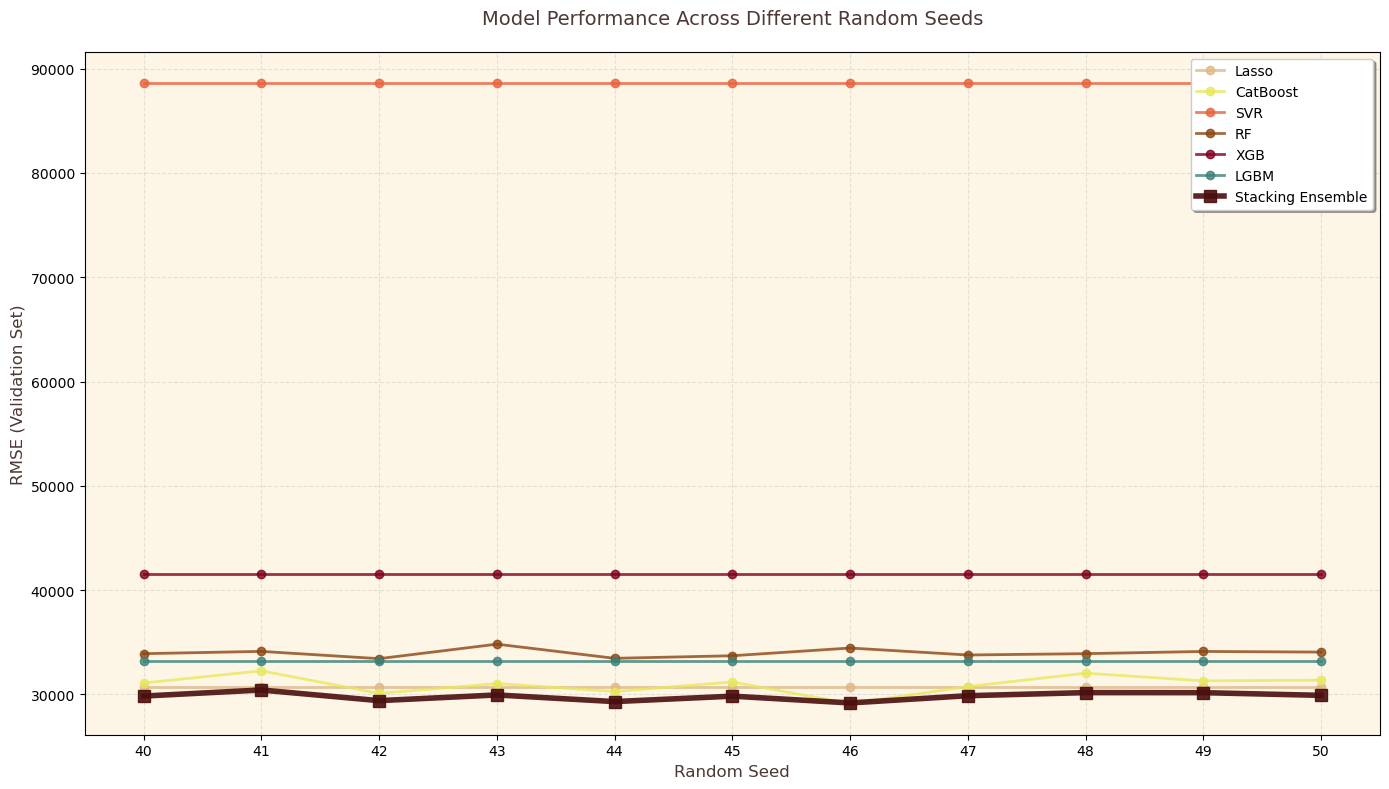

<Figure size 640x480 with 0 Axes>

In [42]:
def plot_seed_comparison(seed_results):
    """Create elegant line plots showing performance across seeds with beige-bordeaux palette."""

    colors = {'Lasso': '#DEB887','CatBoost': "#E8E85E",
              'SVR': "#E7623D",'RF': '#8B4513',
              'XGB': '#800020', 
              'Stacking': '#4A0E0E',
              'LGBM': "#3B8279"}
    
    # Extracting data for plotting
    seeds = list(seed_results.keys())
    
    # Preparing data for individual models
    model_data = {}
    for model_name in ['Lasso', 'CatBoost', 'SVR', 'RF', 'XGB', 'LGBM']:
        model_data[model_name] = []
        for seed in seeds:
            if model_name in seed_results[seed]['individual_models']:
                model_data[model_name].append(seed_results[seed]['individual_models'][model_name])
            else:
                model_data[model_name].append(np.nan)
    
    stacking_rmse = [seed_results[seed]['stacking_rmse'] for seed in seeds]

    plt.figure(figsize=(14, 8))
    
    # Plotting individual models
    for model_name, rmse_values in model_data.items():
        plt.plot(seeds, rmse_values, marker='o', linewidth=2, markersize=6, 
                label=model_name, color=colors[model_name], alpha=0.8)
    
    # Plotting stacking ensemble with emphasis
    plt.plot(seeds, stacking_rmse, marker='s', linewidth=4, markersize=8, 
            label='Stacking Ensemble', color=colors['Stacking'], alpha=0.9)
    
    # Customize the plot
    plt.title('Model Performance Across Different Random Seeds', fontsize=14, pad=20, color = "#4E3836")
    plt.xlabel('Random Seed', fontsize=12, color="#4E3836")
    plt.ylabel('RMSE (Validation Set)', fontsize=12, color = "#4E3836")
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
    plt.gca().set_facecolor('#FDF5E6')
    plt.gcf().patch.set_facecolor('white')
    plt.xticks(seeds)
    plt.tight_layout()

    plt.show()
    return plt.gcf()

fig = plot_seed_comparison(seed_results) 

In [44]:
# Find the best seed based on stacking ensemble performance
def find_best_seed(seed_results):
    """Find the seed that gives the best stacking ensemble performance."""
    best_seed = min(seed_results.keys(), 
                   key=lambda seed: seed_results[seed]['stacking_rmse'])
    
    best_performance = seed_results[best_seed]
    return best_seed, best_performance

best_seed, best_performance = find_best_seed(seed_results)

print(f"Best seed: {best_seed}")
print(f"RMSE: {best_performance['stacking_rmse']:,.2f}")
print(f"R²: {best_performance['stacking_r2']:.4f}")
print(f"MAE: {best_performance['stacking_mae']:,.2f}")

Best seed: 46
RMSE: 29,181.35
R²: 0.8890
MAE: 15,605.69


In [45]:
lasso_model = Lasso(alpha=0.22726857509532503, random_state=42)
catboost_model = CB(depth=4,
                    learning_rate=0.07280162515194599, 
                    iterations=400,
                    l2_leaf_reg=0.006096837447833604,
                    random_state=42)
svr_model = SVR(C=0.7635604502001735, 
                epsilon=0.28940639895970827)
rf_model = RandomForestRegressor(n_estimators=170, 
                                  max_depth=20, 
                                  random_state=42)
lgbm_model = GBM(num_leaves=150,
                    max_depth=25, 
                    learning_rate=0.07280162515194599, 
                    random_state=42)
xgb_model = XGB(n_estimators=170,
                max_depth=170, 
                learning_rate=0.07280162515194599,
                random_state=42)

best_models_combo = [("Lasso", lasso_model), ("CatBoost", catboost_model), ("SVR", svr_model), ("RF", rf_model), ("XGB", xgb_model)]

final_stack = StackingRegressor(
    estimators=best_models_combo,
    final_estimator=Ridge(alpha=0.002527911603259286),
    cv=5,
    n_jobs=-1)

In [52]:
# Fit the final stacking model on the training data
final_stack.fit(train_df, y_train)
# Predict on the validation set
y_pred_final = final_stack.predict(val_df)

# Calculate RMSE manually by taking the square root of MSE
val_rmse = np.sqrt(RMSE(y_val, y_pred_final))
val_r2 = R2(y_val, y_pred_final)
val_mae = MAE(y_val, y_pred_final)

print("Final Stacking Model Performance on Validation Set:")
print(f"Validation RMSE: {val_rmse:,.2f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Validation MAE: {val_mae:,.2f}")

Final Stacking Model Performance on Validation Set:
Validation RMSE: 28,957.34
Validation R²: 0.8907
Validation MAE: 15,504.12


c:\Users\felix\Anaconda\envs\ML_VU\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'Residuals Histogram')

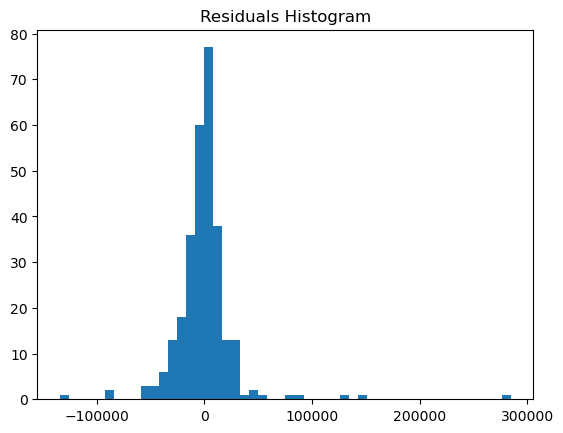

In [47]:
errors = y_val - y_pred_final
plt.hist(errors, bins=50)
plt.title("Residuals Histogram")

Most residuals are centered around 0, suggesting the model is well-calibrated. However, there are some outliers, indicating that the model may struggle with certain data points. This is aalso suggested by MAE being very high compared to the centre of residuals' distribution. MAE is less sensitive to outliers because treats all errors equally, while MSE squares the errors, giving more weight to larger errors. 
This means that MSE is more sensitive to outliers than MAE.


Therefore, MAE should be way less high than MSE, but in this case it is not. This suggests that the model is not performing well on some data points, which may be due to outliers or other factors. In fact, we didn't remove outliers from validation set and test, on porpuse. 

### Prediction on Test set and creation of submission file for Kaggle

In [109]:
y_test_pred = final_stack.predict(test_df)

c:\Users\felix\Anaconda\envs\ML_VU\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [49]:
test_rmse = np.sqrt(RMSE(y_val, y_pred_final))
test_r2 = R2(y_val, y_pred_final)
test_mae = MAE(y_val, y_pred_final)

print("Final Stacking Model Performance on Validation Set:")
print(f"Validation RMSE: {test_rmse:,.2f}")
print(f"Validation R²: {test_r2:.4f}")
print(f"Validation MAE: {test_mae:,.2f}")

Final Stacking Model Performance on Validation Set:
Validation RMSE: 28,957.34
Validation R²: 0.8907
Validation MAE: 15,504.12


In [51]:
submission = pd.DataFrame({"Id": test_ids,
                           "SalePrice": y_test_pred})
submission.to_csv("submission.csv", index=False)

## Predicted vs Actual Analysis

Analyze model performance through predicted vs actual plots and residual analysis.

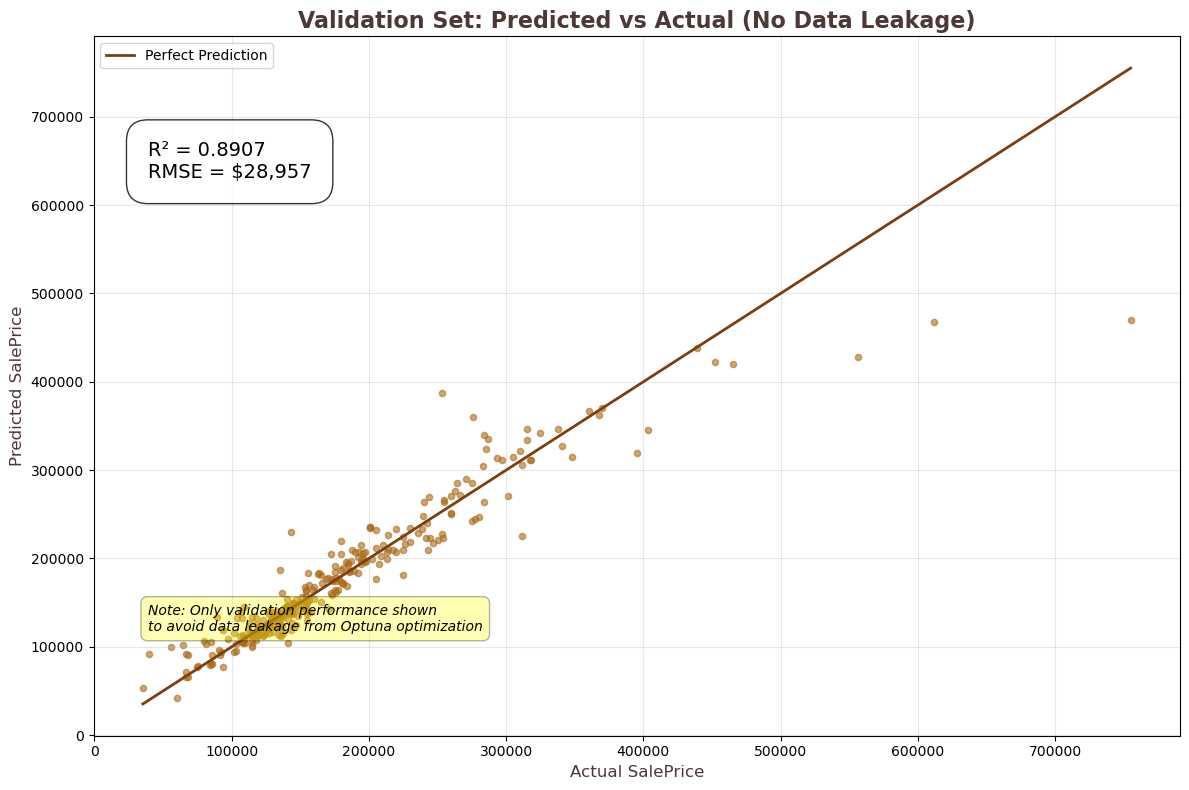

Validation R²: 0.8907
Validation RMSE: $28,957


In [114]:
def plot_predicted_vs_actual():
    """
    FIXED VERSION: Create validation predicted vs actual plot with proper matplotlib syntax.
    Shows only validation performance to avoid data leakage issues.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import r2_score, mean_squared_error

    colors = {
        'points': "#AA6B18",
        'line': "#7D3E10",
        'background': "#F2E9DA"
    }
    
    # Create figure and axis properly
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')

    # Create scatter plot using ax.scatter (not just scatter)
    ax.scatter(y_val, y_pred_final, alpha=0.6, color=colors['points'], s=20)
    
    # Create perfect prediction line
    min_val = min(y_val.min(), y_pred_final.min())
    max_val = max(y_val.max(), y_pred_final.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            color=colors['line'], linewidth=2, label='Perfect Prediction')
    
    # Set labels and title using ax methods
    ax.set_xlabel('Actual SalePrice', fontsize=12, color="#4E3836")
    ax.set_ylabel('Predicted SalePrice', fontsize=12, color="#4E3836")
    ax.set_title('Validation Set: Predicted vs Actual (No Data Leakage)', 
                 fontsize=16, color="#4E3836", fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Metrics 
    val_r2 = r2_score(y_val, y_pred_final)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_final))
    
    # Add metrics text box
    ax.text(0.05, 0.85, f"R² = {val_r2:.4f}\nRMSE = ${val_rmse:,.0f}", transform=ax.transAxes, fontsize=14, 
            verticalalignment='top', bbox=dict(boxstyle='round,pad=1.1', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'val_r2': val_r2,
        'val_rmse': val_rmse
    }

# Generate the validation plot
validation_results = plot_predicted_vs_actual()
print(f"Validation R²: {validation_results['val_r2']:.4f}")
print(f"Validation RMSE: ${validation_results['val_rmse']:,.0f}")
